In [53]:
%matplotlib inline
import numpy as np
import pylab as pl
import seaborn as sbn

# Résolution d'équations différentielles par méthode pseudo-spectrale
## Projection sur polynomes de Tchebychev

Les méthodes pseudo-spectrales sont un type de méthodes numériques utilisées pour la résolution des équations différentielles partielles. Elles sont proches des méthodes spectrales, mais sont appliqué sur des noeuds de calculs, permettant l'évaluation des dérivées partielles sur un maillage du domaine. Cela mène à des calculs considérablements accélérés pour peu que l'on choisisse des algorithmes adaptés.

En bref, il s'agira d'approcher notre grandeur par une combinaison linéaire de fonctions connus (série) pondérés de façon à s'ajuster à la fonction d'origine. Un cas "classique" est l'utilisation des séries de Fourrier pour approcher un signal périodique.

Ainsi, le code suivant fait l'approximation d'une fonction carré via une série de Fourrier. Sur la figure, il y a le signal initial, et l'approximation via une série de fourrier tronqué respectivement à la 200ème et 20ème harmonique.

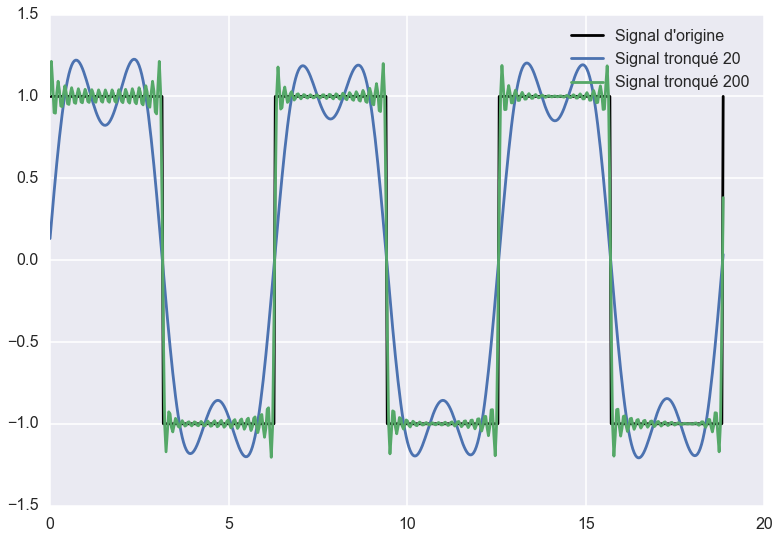

In [54]:
from scipy.signal import sawtooth, square
from scipy.fftpack import rfft, irfft
sbn.set_context('poster')

x = np.linspace(0, 3*np.pi*2., 500)
y = square(x)
y_fourrier200 = rfft(y)
y_fourrier20 = rfft(y)
y_fourrier200[200:] = 0
y_fourrier20[20:] = 0
y_real20 = irfft(y_fourrier20)
y_real200 = irfft(y_fourrier200)

pl.plot(x, y, color='black')
pl.plot(x, y_real20)
pl.plot(x, y_real200)
pl.legend(["Signal d'origine", "Signal tronqué 20", "Signal tronqué 200"])
pl.show()

Les séries de fourrier est qu'elles ne sont appliquables qu'avec des fonctions périodiques. Il est nécessaire d'utiliser d'autres classes de fonction pour d'autres signaux.
Citons entre autre les polynomes de Legendre et ceux de Tchebychev.

Avec ceux de Tchebychev :

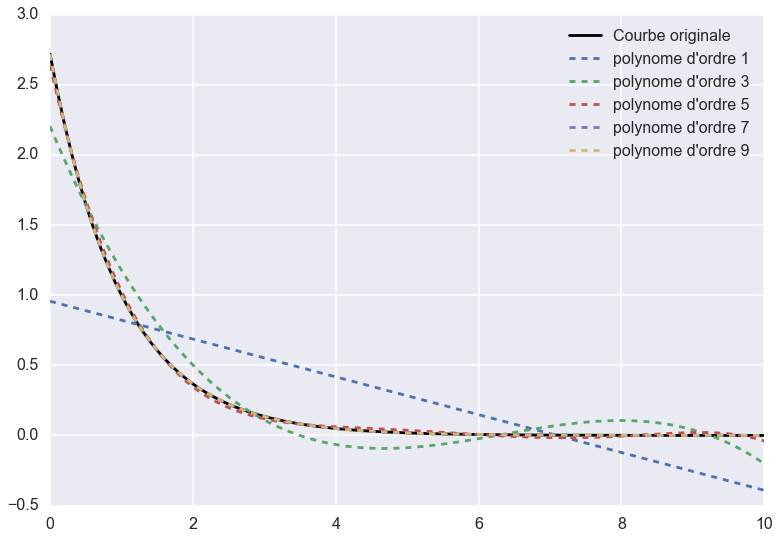

In [55]:
from numpy.polynomial import chebyshev as C

x = np.linspace(0, 10, 100)
y = np.exp(1 - x)
pl.plot(x, y, color='black')
legend = ['Courbe originale']
for n in range(1, 10, 2):
    coeffs_tcheby = C.chebfit(x, y, n)
    y_tch = C.chebval(x, coeffs_tcheby)
    pl.plot(x, y_tch, linestyle='--')
    legend.append("polynome d'ordre %i" % n)
pl.legend(legend)
pl.show()

L'interet majeu de l'utilisation de tels polynomes est que leur dérivées et primitives sont calculable directement par récursivité.

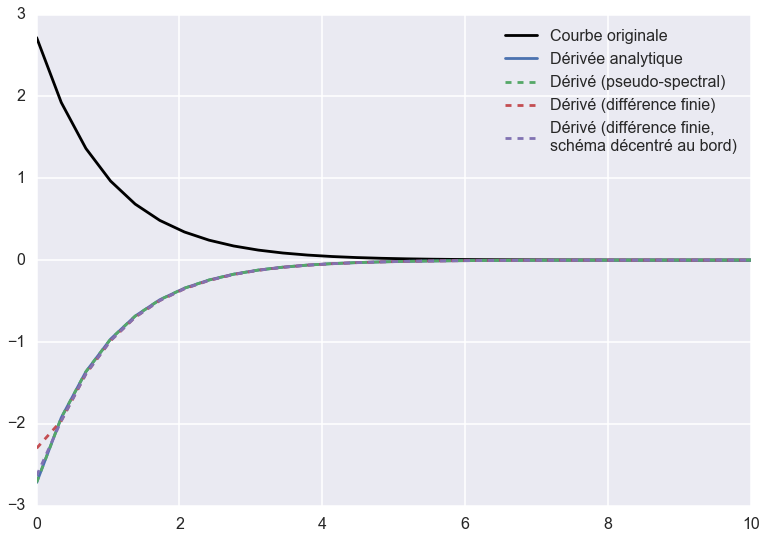

In [56]:
x = np.linspace(0, 10, 30)
y = np.exp(1 - x)
pl.plot(x, y, color='black')
pl.plot(x, -np.exp(1-x))
legend = ['Courbe originale', 'Dérivée analytique']
coeffs_tcheby = C.chebfit(x, y, 10)
coeffs_tcheby_diff = C.chebder(coeffs_tcheby)
y_tch = C.chebval(x, coeffs_tcheby_diff)
pl.plot(x, y_tch, linestyle='--')
legend.append('Dérivé (pseudo-spectral)')
pl.plot(x, np.gradient(y)/np.gradient(x), linestyle='--')
legend.append('Dérivé (différence finie)')
pl.plot(x, np.gradient(y, edge_order=2)/np.gradient(x, edge_order=2), linestyle='--')
legend.append('Dérivé (différence finie,\nschéma décentré au bord)')
pl.legend(legend)
pl.show()

On observe en particulier que le traitement des conditions de bord est plus "propre" que lors de l'utilisation d'un schéma différence fini. La courbe est confondue avec la de la dérivée exacte. Il est nécessaire d'utiliser un schéma différence fini mixte (centré pour les valeur milieu, décentré sur les bords) ou de rajouter des points factices au bord pour éviter ces erreurs, ce qui peut rendre peu évident la mise en place de conditions de bord.

## Application : l'équation de la chaleur

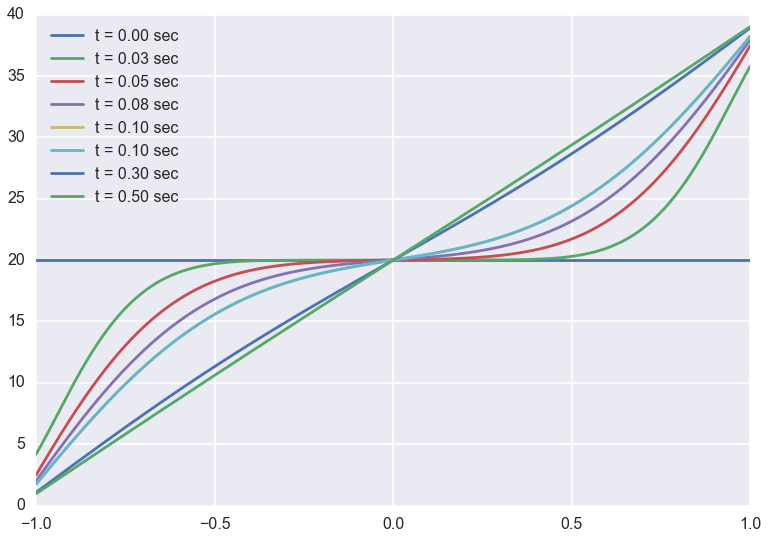

In [57]:
from scipy.integrate import odeint

def fourrier(T, t, x, k, r, rho, cp, h, T_ext_l, T_ext_r, N):
    """
    The heat equation : we return the rhs.
    This function will be used via the odeint algorithm.
    """
    
    # We use a dirichlet DBC : fixed value of T(x=0)
    # T[-1] = T_ext_r + 10 * np.cos(t)
    # We adjust a N basis of Tchebychev polynomial according the T values (taking account the BDC)
    r = r * np.cos(20*t)
    cheb_coeffs = C.chebfit(x, T, N)
    # We apply the derivative on the Tchebychev polynomial
    chebdiff = C.chebder(cheb_coeffs, 1)
    # Go back to the real space : we now have the first order derivative
    dxT = C.chebval(x, chebdiff)
    # This time, a Cauchy BDC is used (convective-like BDC)
    dxT[0] =  h * (T[0] - T_ext_l) # + 10 * np.cos(t)))
    dxT[-1] = h * (T_ext_r - T[-1]) # * np.cos(t) - T[-1])
    # We do the same thing for the 2nd derivative
    cheb_coeffs = C.chebfit(x, dxT, N)
    chebdiff = C.chebder(cheb_coeffs, 1)
    dxxT = C.chebval(x, chebdiff)
    
    # We have all we need, ie the 2nd derivative with the boundary conditions that we want.
    
    dtT = (k*(dxxT) + r) / (rho * cp)
    
    return dtT
  

x, dx = np.linspace(-1, 1, 400, retstep=True)
T0 = np.zeros(x.shape) + 20

k = 1
r = 0
cp = 1.
rho = 1
h = 20
T_ext_l = 0
T_ext_r = 40

N = 10

t = np.concatenate([np.linspace(0, .1, 5), np.linspace(.1, .5, 3)])

solutions = odeint(fourrier, T0, t, args=(x, k, r, rho, cp, h, T_ext_l, T_ext_r, N))

for sol, t_ in zip(solutions, t):
    pl.plot(x, sol, label='t = %.2f sec'%t_)
pl.legend(loc='best')
pl.show()